In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df1 = pd.read_csv('historik_antam.csv')
df2 = pd.read_pickle('UpdateHargaEmas.pkl')

In [3]:
df1

,Unnamed: 0,datetime,price,year,month,day
0,0,2010-01-04 09:07:00,408000,2010,1,4
1,1,2010-01-05 09:28:00,410000,2010,1,5
2,2,2010-01-06 07:01:00,410000,2010,1,6
3,3,2010-01-07 09:45:00,412000,2010,1,7
4,4,2010-01-08 09:37:00,410000,2010,1,8
...,...,...,...,...,...,...
4086,4086,2023-10-04 08:00:33,1040000,2023,10,4
4087,4087,2023-10-05 08:00:05,1043000,2023,10,5
4088,4088,2023-10-06 08:13:24,1043000,2023,10,6
4089,4089,2023-10-07 08:27:44,1047000,2023,10,7


In [4]:
df2

,datetime,price,year,month,day
0,2023-10-08 05:06:43,1047000,2023,10,8


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4091 entries, 0 to 4090
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4091 non-null   int64 
 1   datetime    4091 non-null   object
 2   price       4091 non-null   int64 
 3   year        4091 non-null   int64 
 4   month       4091 non-null   int64 
 5   day         4091 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 191.9+ KB


In [6]:
df1.drop(columns='Unnamed: 0', inplace=True)

In [7]:
df1['datetime'] = pd.to_datetime(df1['datetime'])

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4091 entries, 0 to 4090
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  4091 non-null   datetime64[ns]
 1   price     4091 non-null   int64         
 2   year      4091 non-null   int64         
 3   month     4091 non-null   int64         
 4   day       4091 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 159.9 KB


In [9]:
df1['datetime'] = pd.DatetimeIndex(df1['datetime']).date

In [10]:
df1

,datetime,price,year,month,day
0,2010-01-04,408000,2010,1,4
1,2010-01-05,410000,2010,1,5
2,2010-01-06,410000,2010,1,6
3,2010-01-07,412000,2010,1,7
4,2010-01-08,410000,2010,1,8
...,...,...,...,...,...
4086,2023-10-04,1040000,2023,10,4
4087,2023-10-05,1043000,2023,10,5
4088,2023-10-06,1043000,2023,10,6
4089,2023-10-07,1047000,2023,10,7


In [11]:
train = df1[0:3691]
test = df1[3691:]

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3691 entries, 0 to 3690
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  3691 non-null   object
 1   price     3691 non-null   int64 
 2   year      3691 non-null   int64 
 3   month     3691 non-null   int64 
 4   day       3691 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 144.3+ KB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 3691 to 4090
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  400 non-null    object
 1   price     400 non-null    int64 
 2   year      400 non-null    int64 
 3   month     400 non-null    int64 
 4   day       400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


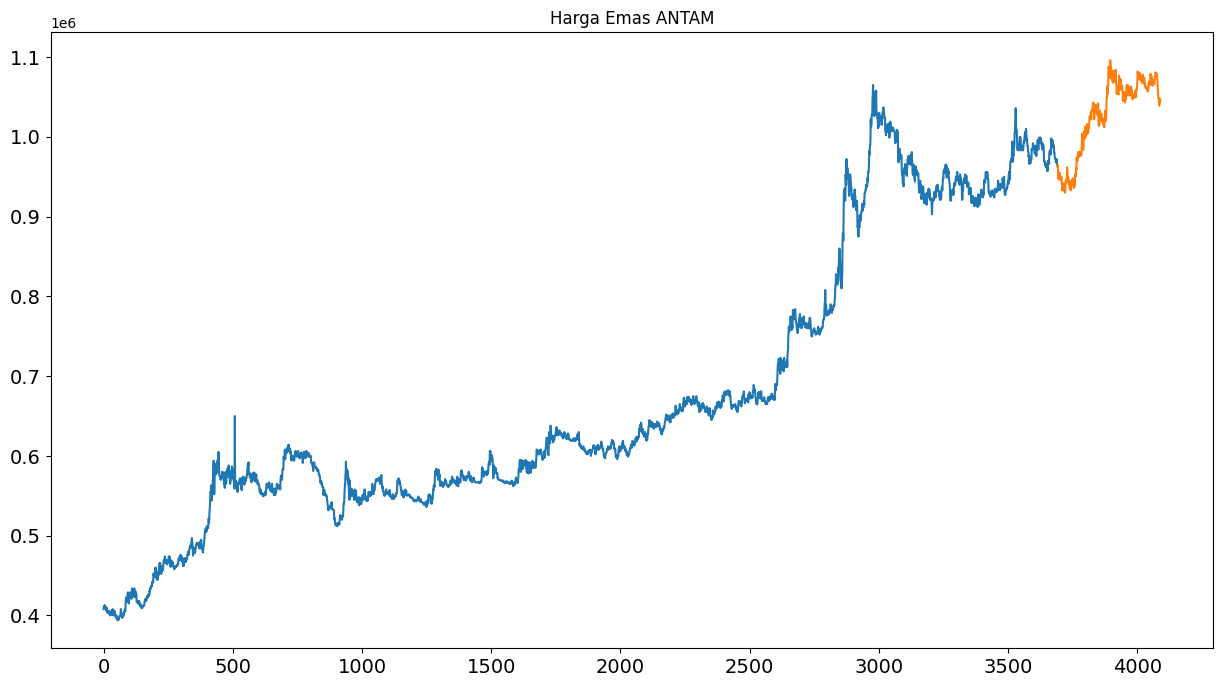

In [13]:
train['price'].plot(figsize=(15,8), title= 'Harga Emas ANTAM', fontsize=14)
test['price'].plot(figsize=(15,8), title= 'Harga Emas ANTAM', fontsize=14)

plt.show()

In [14]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [15]:
check_stationarity(train['price'])

ADF Statistic: -0.496009
p-value: 0.892793
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Non-stationary


<Axes: xlabel='datetime'>

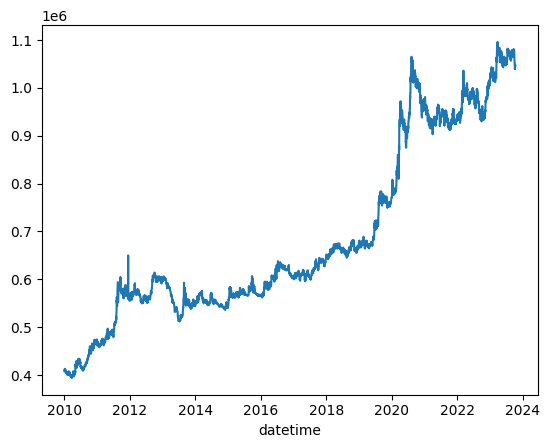

In [16]:
df1.set_index('datetime', inplace=True)
df1['price'].plot()

In [21]:
df1

,price,year,month,day
datetime,,,,
2010-01-04,408000,2010,1,4
2010-01-05,410000,2010,1,5
2010-01-06,410000,2010,1,6
2010-01-07,412000,2010,1,7
2010-01-08,410000,2010,1,8
...,...,...,...,...
2023-10-04,1040000,2023,10,4
2023-10-05,1043000,2023,10,5
2023-10-06,1043000,2023,10,6


additive


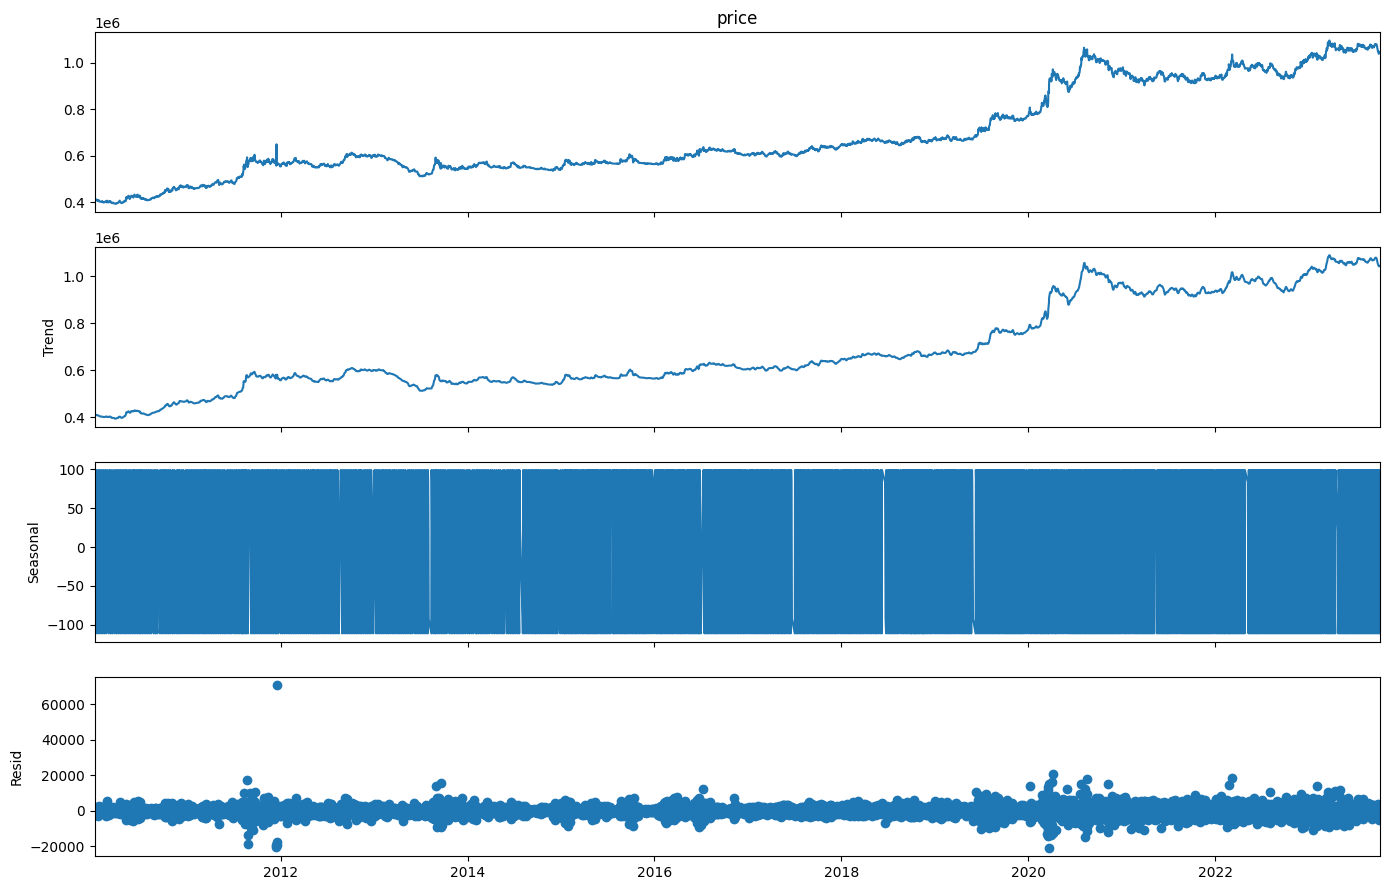

additive


In [37]:
print('additive')
res = seasonal_decompose(df1['price'], model='additive', period=5)
ax=res.plot()
plt.show()
print('additive')

multiplicative


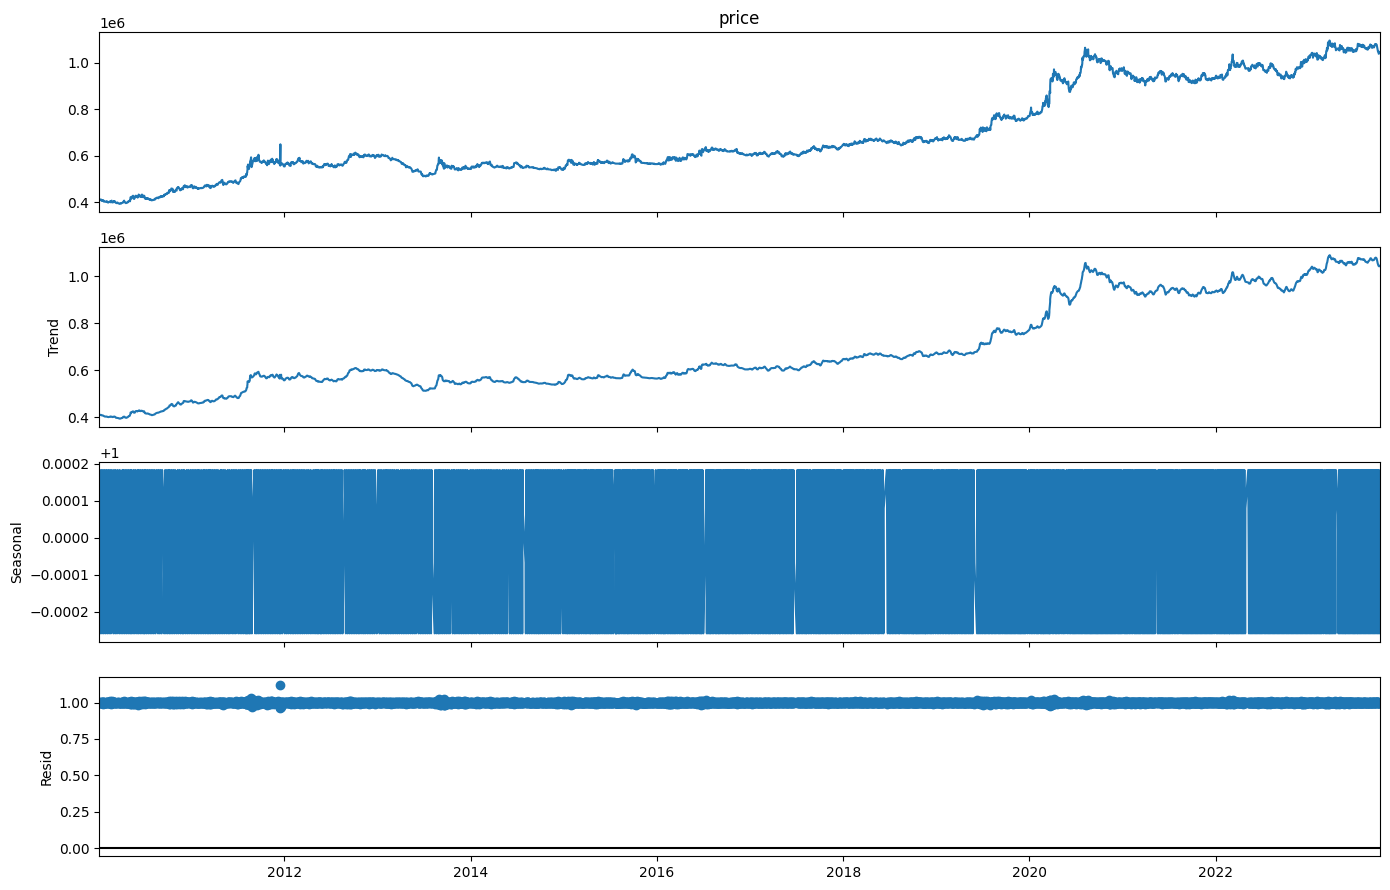

multiplicative


In [36]:
print('multiplicative')
res = seasonal_decompose(df1['price'], model='multiplicative', period=5)
ax=res.plot()
plt.show()
print('multiplicative')